# Ponderada Jefferson Semana 9
## Aluna Mariana Brasil Gorresen

### Importando bibliotecas e dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# https://www.kaggle.com/datasets/shenba/time-series-datasets
df = pd.read_csv("/content/Electric_Production.csv")
df = df.rename(columns={'DATE': 'ds', 'IPG2211A2N': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.dropna()

### Predizendo com Prophet Model

In [4]:
# Prophet model
prophet_model = Prophet()
prophet_model.fit(df)

future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsyov7oj/dmoo7wbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsyov7oj/ax0gk281.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26859', 'data', 'file=/tmp/tmpmsyov7oj/dmoo7wbh.json', 'init=/tmp/tmpmsyov7oj/ax0gk281.json', 'output', 'file=/tmp/tmpmsyov7oj/prophet_model7n7uzq2h/prophet_model-20250402013314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

### Pre processamento de dados

In [5]:
# Preparação de dados para LSTM
data = df[['y']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Criar sequências
def create_sequences(data, window):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(x), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)

# Redimensionar para [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

### Treinando com LSTM Model

In [6]:
# Treinamento LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, verbose=1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2208
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0855
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0149
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0152
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0135
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0132
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0139
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125
Epoch 16/20
13/13 ━━━━━

### Predizendo com LSTM MODEL

In [7]:
# Predição
input_seq = scaled_data[-window_size:].reshape(1, window_size, 1)
lstm_predictions = []
for _ in range(12):
    next_val = model.predict(input_seq, verbose=0)[0]
    lstm_predictions.append(next_val[0])
    input_seq = np.append(input_seq[:, 1:, :], [[next_val]], axis=1)

# Desnormalizar
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))
lstm_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


<ipython-input-7-a08c336ded83>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lstm_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


### Gráfico de comparação de resultado de predição dos modelos LSTM e Prophet

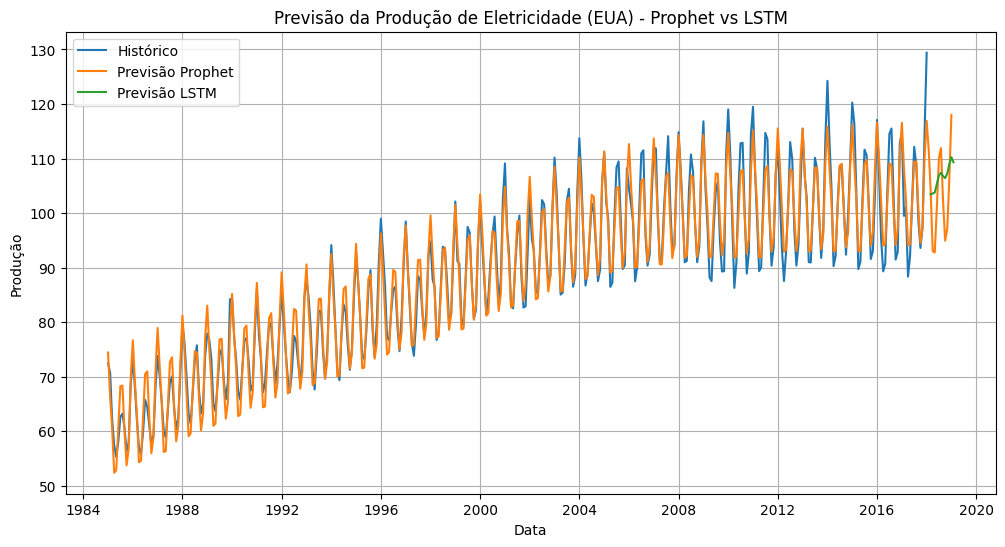

In [8]:
# Comparação de resultados
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Histórico')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão Prophet')
plt.plot(lstm_dates, lstm_predictions, label='Previsão LSTM')
plt.legend()
plt.title("Previsão da Produção de Eletricidade (EUA) - Prophet vs LSTM")
plt.xlabel("Data")
plt.ylabel("Produção")
plt.grid()
plt.show()
